# Importing libraries and cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
import hdbscan
import pickle

import functions
from functions import k_means_model,dbscan_model,scatter_plot,hdbscan_model,gm_model,mshift_model

Importing plotly failed. Interactive plots will not work.


In [2]:
# Disabling a specific type of warning 
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [3]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK and filtering the dataset to include only sales related to products.

In [4]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df_fltrd = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df_fltrd = df_fltrd[df_fltrd.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df_fltrd.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df_fltrd['TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

# Feature Engineering

**Average Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. Wholesale customers typically spend more money on their purchases compared to retail customers.

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [5]:
def feat_eng(df):
    ''' This function, does feature engineering and returns the constructed dataframe.
    '''

    # Average quantity per item per order
    # Grouping by StockCode, in case in the same invoice client has added the product more than once
    item_quant = df.groupby(['CustomerID','InvoiceNo','StockCode'])['Quantity'].sum().reset_index()
    item_quant_per_cust = item_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantityPerItem'})

    cust = item_quant_per_cust.copy()


    # Anerage quantity per order
    avrg_quant = df.groupby(['CustomerID','InvoiceNo'])['Quantity'].sum().reset_index()
    avrg_quant_per_cust = avrg_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantity'})

    cust = pd.merge(cust, avrg_quant_per_cust, how='left', on='CustomerID')


    # Average value per order
    order_val = df.groupby(['CustomerID','InvoiceNo'])['TotalPrice'].sum().reset_index()
    avrg_val = order_val.groupby('CustomerID')['TotalPrice'].mean().round(2).reset_index().rename(columns={'TotalPrice':'AvrgOrderValue'})

    cust = pd.merge(cust, avrg_val, how='left', on='CustomerID')


    # Setting CustomerID as index
    cust.set_index('CustomerID', inplace=True)

    return cust   

In [6]:
df_fltrd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348887 entries, 0 to 524864
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    348887 non-null  object        
 1   StockCode    348887 non-null  object        
 2   Description  348887 non-null  object        
 3   Quantity     348887 non-null  int64         
 4   InvoiceDate  348887 non-null  datetime64[ns]
 5   UnitPrice    348887 non-null  float64       
 6   CustomerID   348887 non-null  Int64         
 7   Country      348887 non-null  object        
 8   TotalPrice   348887 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


In [7]:
df_fltrd.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom,17.7
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom,33.2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.5


In [8]:
cust = feat_eng(df_fltrd)
cust.head()

,AvrgQuantityPerItem,AvrgQuantity,AvrgOrderValue
CustomerID,,,
12346,74215.00,74215.00,92768.75
12747,12.38,115.91,429.32
12748,5.87,121.61,223.40
12749,7.42,294.00,808.79
12820,12.24,180.50,234.74


In [9]:
cust.describe()

,AvrgQuantityPerItem,AvrgQuantity,AvrgOrderValue
count,3917.000000,3917.000000,3917.00000
mean,48.482658,243.009262,415.62109
std,1267.497164,1374.599856,2049.73739
min,1.000000,1.000000,3.75000
25%,5.680000,90.000000,178.35000
50%,9.840000,155.000000,286.93000
75%,14.670000,260.000000,424.86000
max,74215.000000,74215.000000,92768.75000


# EDA

Based on the following analyis I see that I have many outliers and noise in my data. These are the conclusions drawn from this 'EDA' section:

There is an important decision to be made. I see that I have two types of outliers/ noise.
- One comes from the two invoices with number '581483','541431' (two outliers). The Quantity and value of these invoices is huge, not comparable at all with the rest of the 19962 invoices. Also, these 2 invoices, one is from a client that ordered only once (that very big order of only one item) and the other client had this huge order and only two more items at another time. That makes me think that they are not really repeated wholesale customers, and are stand-alone cases that since they differ so much for the model accuracy can be disadvantage.
- Then when I see my data without these two, I can see the noise around my data. This second type of outliers they still need to be treated, but their scale is more comparable to the rest of the data.

I am going to do outlier clipping for the noise at my data, but when I do it without removing the 2 outliers first, the dataset is still very noisy and I don't trust that the trained ML model can be accurate enough.
For that reason I decided in the next section of the notebook 'Outliers' to treat these two types differently.

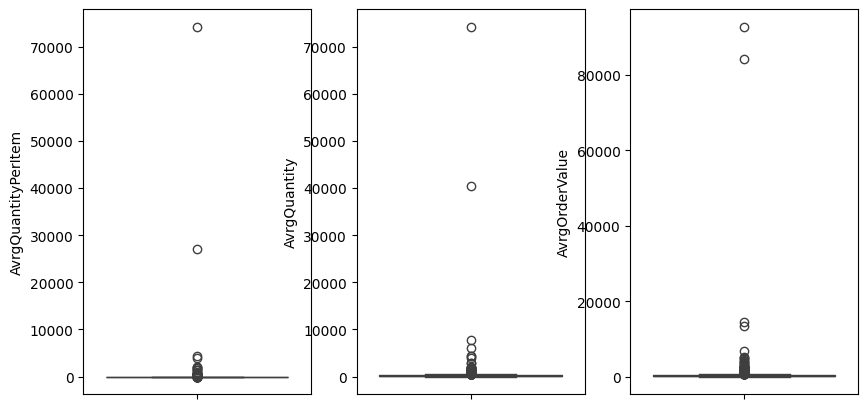

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.boxplot(data=cust['AvrgQuantityPerItem'], ax=ax[0]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[2]) 

plt.show()

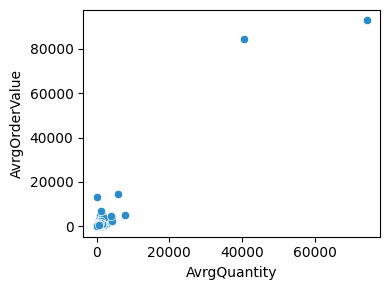

In [11]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue', color='#2C8CCB')
plt.tight_layout()  # Adjust layout to prevent cropping
plt.savefig("../images/scatterplot-outliers1.png")
plt.show()

In [12]:
# Looking into the two big outliers
df[df.InvoiceNo.isin(['581483','541431'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [13]:
df[df.CustomerID.isin([12346,16446])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
188029,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom
188030,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


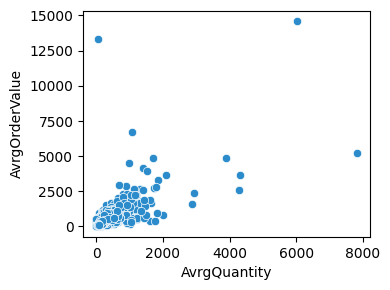

In [14]:
# Checking the scatterplots without the two big outliers, to see my data a bit more clearly
# I am doing he same process as above, using the function I defined
# note: this is just to see how it looks, in the next section, I will do outlier scaling to range for these two outliers
cust_fltrd = feat_eng(df_fltrd[~df_fltrd.InvoiceNo.isin(['581483','541431'])])

# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='AvrgQuantity', y='AvrgOrderValue', color='#2C8CCB')
plt.tight_layout()
plt.savefig("../images/scatterplot-ouliers2.png")
plt.show()

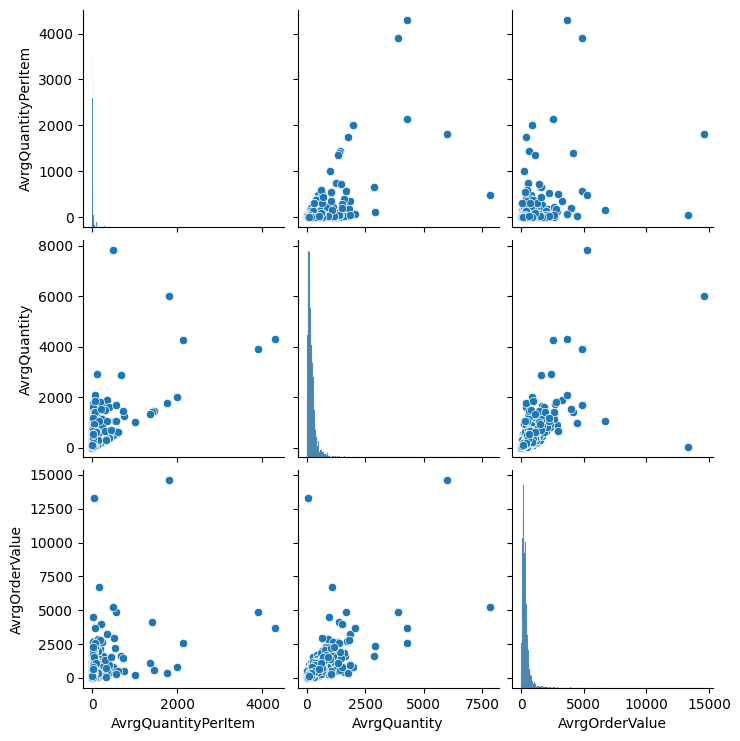

In [15]:
sns.pairplot(cust_fltrd)

# Handling outliers

Based on the noise and outliers that I identified in the previous section, I am going to implement two different approaches for the two types of outliers.
- to the two outliers with the huge difference in scale, I am going to do scaling to a range, scaling them to highest next value (after these two).
- then after completing that, I will do outlier clipping for the rest of the outliers/ noice. I trust that in this way my model will have better scale and will have more accuracy. For that I will use the Stardard Deciation method, by z-score to +-3σ (σ is the standard deviation).

Helpful aricle:
https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

In [16]:
def outlier_scaling(df):
    '''Function that performs outlier scaling.
    There are two outliers that have been spoted throught the EDA, that have huge difference in scale, and seem to be two stand-alone
    cases (they are not repeating customers).
    Through the analysis I have decided to scale the Quantity of them to the next highest value after these two."
    Receives the daframe as parameter and returns the updated dataframe with outlier clipping, 
    and updated the Total Price column accordingly.'''

    condition = df.InvoiceNo.isin(['581483','541431'])

    df.loc[condition,'Quantity'] = df.Quantity.sort_values(ascending=False).values[2]
    df.loc[condition,'TotalPrice'] = df.Quantity * df.UnitPrice  

    return df

In [17]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df_fltrd_sc = outlier_scaling(df_fltrd.copy())

In [18]:
# Creating the updated customer dataframe
cust_norm = feat_eng(df_fltrd_sc)

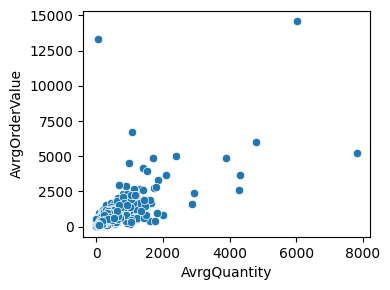

In [19]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm, x='AvrgQuantity', y='AvrgOrderValue')
plt.tight_layout()
plt.show()

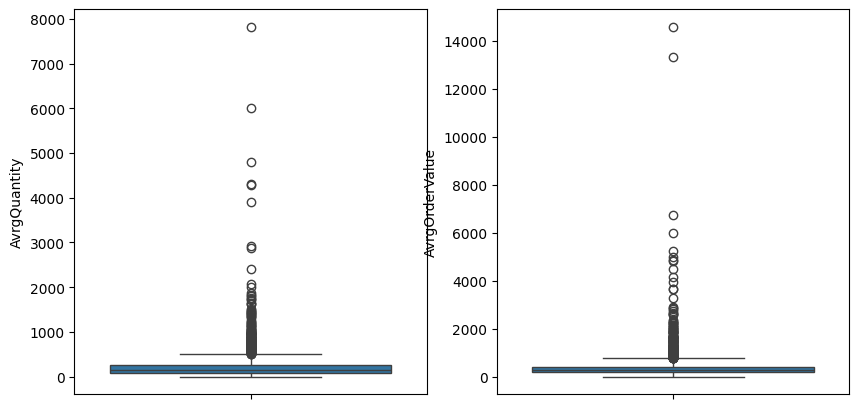

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(data=cust_norm['AvrgQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [21]:
cust_norm.columns

Index(['AvrgQuantityPerItem', 'AvrgQuantity', 'AvrgOrderValue'], dtype='object')

In [22]:
# Creating a copy of the dataframe for the clipping
cust_norm_clip = cust_norm.copy()

In [23]:
def outliers_clipping_STD(df, col_name, z_score):
    ''' Function that does outlier clipping based on the Standard Deviation Method.
    It receives as parameters the dataframe and the column where oultier clipping will be performed.
    Returns updated dataframe and prints how many instances had outlier clipping performed to them.
    '''

    # Checking if column if integer or float type, to format accordingly
    # checking only upper limit. I don't have lower limit, cause everything start from 0
    if df[col_name].dtype == 'int64':        
        tq_UpperLimit = (df[col_name].mean() + df[col_name].std()*3).round(0).astype(int)
    else:
        tq_UpperLimit = (df[col_name].mean() + df[col_name].std()*3).round(2)         

    
    print("Instances that needed outlier clipping: ", df[df[col_name] > tq_UpperLimit].shape[0],
              ", out of total instances: ",df[col_name].shape[0])
    
    df.loc[df[col_name] > tq_UpperLimit , col_name] = tq_UpperLimit  

    return df

In [24]:
# Clipping outliers witht the Standard Deviation Method, with the custom function

# setting the z-score at 3, for the outlier clipping with the standard deviation method
z_score = 3

cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'AvrgQuantityPerItem', z_score)
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'AvrgQuantity', z_score)
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'AvrgOrderValue', z_score)

Instances that needed outlier clipping:  23 , out of total instances:  3917
Instances that needed outlier clipping:  42 , out of total instances:  3917
Instances that needed outlier clipping:  44 , out of total instances:  3917


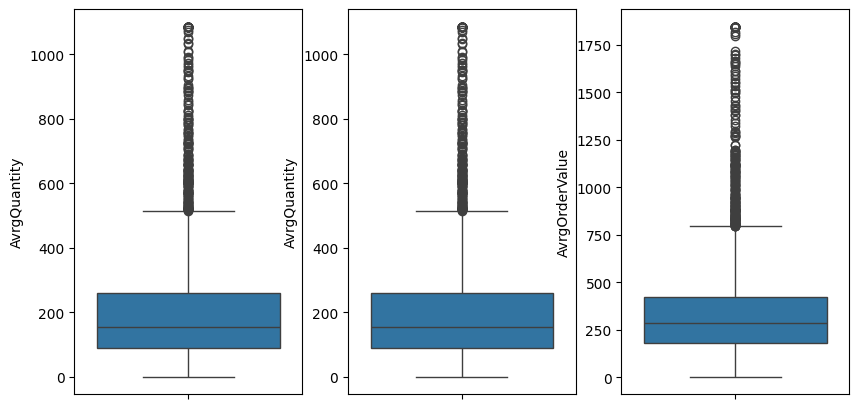

In [25]:
# Boxplot looks much better
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.boxplot(data=cust_norm_clip['AvrgQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm_clip['AvrgQuantity'], ax=ax[1]) 
sns.boxplot(data=cust_norm_clip['AvrgOrderValue'], ax=ax[2]) 

plt.show()

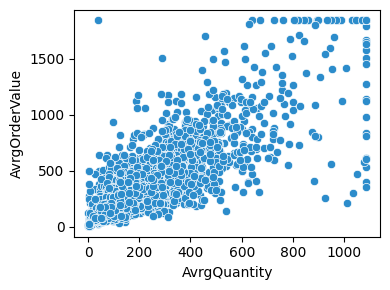

In [26]:
# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm_clip, x='AvrgQuantity', y='AvrgOrderValue', color='#2C8CCB')
plt.tight_layout()
plt.savefig("../images/scatterplot-ouliers3.png")
plt.show()

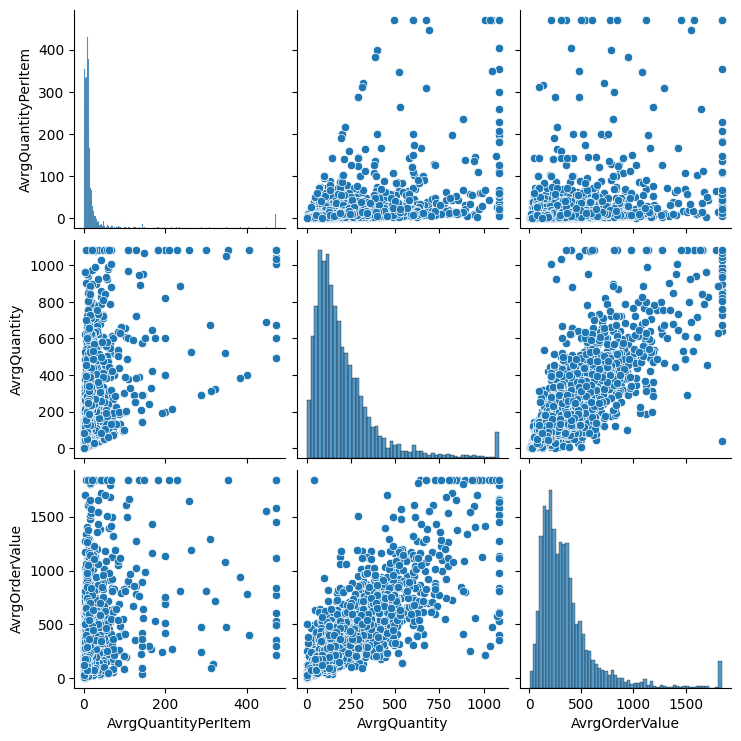

In [27]:
# looking much better
sns.pairplot(cust_norm_clip)

# Normalizing data

There are various methods to normalize the data, such as min-max scaling, z-score scaling, or log transformation. Here I tried the first two, but I will choose the standardization (z-score scaling) that is less sensitive to outliers than min-max scaling (where scale is heavily influenced by the extreme maximum and minimum values).

In [28]:
cust_norm_clip.head()

,AvrgQuantityPerItem,AvrgQuantity,AvrgOrderValue
CustomerID,,,
12346,471.27,1085.77,1845.31
12747,12.38,115.91,429.32
12748,5.87,121.61,223.40
12749,7.42,294.00,808.79
12820,12.24,180.50,234.74


### StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 1.

$$z = \frac{(x-mean(x))}{\sigma}$$

In [29]:
def scaling_data(df):
    ''' Scaling data using the Standard Scaler. Returns the scaled dataframe.'''
    scaler = StandardScaler()

    scaler.fit(df)

    # applying the transformation
    df_stndrd = scaler.transform(df)

    df_stndrd = pd.DataFrame(df_stndrd, columns = df.columns, index=df.index)

    return df_stndrd

In [30]:
# Scaling the data, function
cust_norm_clip_stndrd = scaling_data(cust_norm_clip)

In [31]:
cust_norm_clip_stndrd.head()

,AvrgQuantityPerItem,AvrgQuantity,AvrgOrderValue
CustomerID,,,
12346,10.005464,4.865783,5.154360
12747,-0.132466,-0.491018,0.255785
12748,-0.276287,-0.459535,-0.456589
12749,-0.242043,0.492622,1.568550
12820,-0.135559,-0.134269,-0.417358


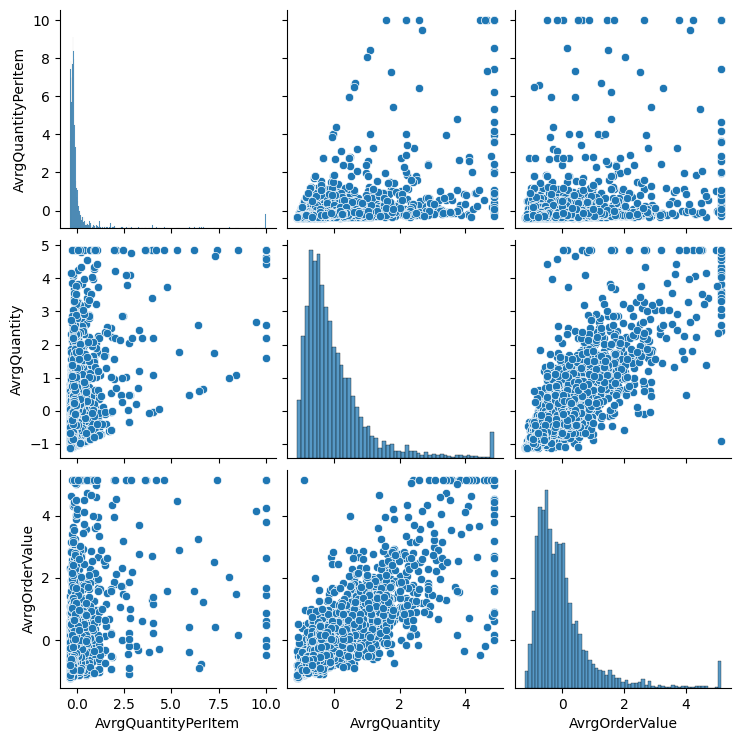

In [32]:
sns.pairplot(cust_norm_clip_stndrd)

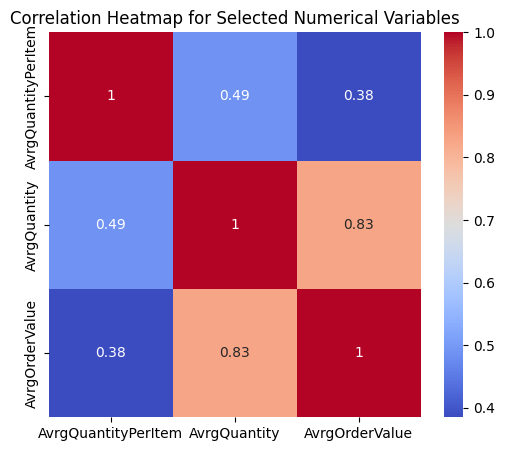

In [33]:
# checking correlation
correlation_matrix = cust_norm_clip_stndrd.corr()


plt.figure(figsize=(6, 5))

# Drawing the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

Average Quantity and Average Order Value have a high correlation coefficient of 0.83, and this suggests a strong linear relationship between the two features. Managing this multicollinearity is important as it can impact the performance and interpretability of clustering algorithms that will follow.

iven this multicollinearity, I will try to use dimensionality reduction. I do not want yet to drop one of the correlated features, in case I loose some info that could have contributed to clustering. After I do the dimensionality reduction, I will check again for correlation, to make sure I don't have high values there.

Also in the clustering, I can make some tests with using only two features from my original ones, using only the Average Quantity per Item and the Average Order Value.

# Dimensionality reduction

Non-linear dimensionality reduction through Isometric Mapping.

In [34]:
# Create an Isomap object with the desired number of components
isomap = Isomap(n_neighbors=5, n_components=2)

# Fit the Isomap model to the data and transform it to the lower-dimensional space
cust_norm_clip_stndrd_reduced = isomap.fit_transform(cust_norm_clip_stndrd)

In [35]:
cust_norm_clip_stndrd_reduced = pd.DataFrame(cust_norm_clip_stndrd_reduced, columns = ['Component 1', 'Component 2'], 
                                             index=cust_norm_clip_stndrd.index)
cust_norm_clip_stndrd_reduced.head()     

,Component 1,Component 2
CustomerID,,
12346,13.569355,6.275006
12747,-0.311543,-0.084982
12748,-0.836110,0.090385
12749,1.064134,-1.701653
12820,-0.396199,0.225415


<Axes: xlabel='Component 1', ylabel='Component 2'>

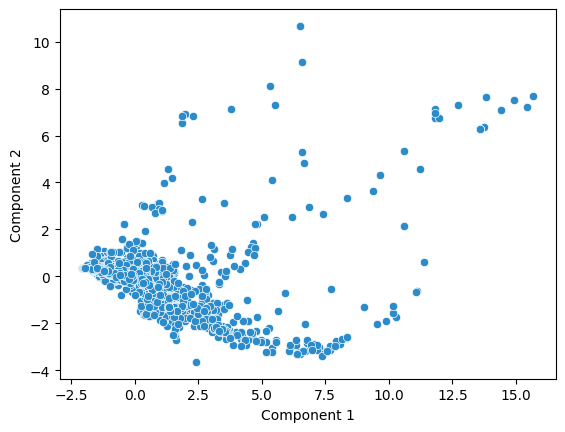

In [36]:
sns.scatterplot(data=cust_norm_clip_stndrd_reduced, x='Component 1', y='Component 2', color='#2C8CCB')

In [37]:
correlation = cust_norm_clip_stndrd_reduced['Component 1'].corr(cust_norm_clip_stndrd_reduced['Component 2'])
correlation

# very small correlation, I do not have to worry for multicollinearity

2.98083635511657e-17

# Considerations

For now I will move on, dropping the feature of average quantity per order for the majority of the tests. That is because it has high correlation with the Average order value. 
So the features I will do my clustering with are: Average order value, and Average quantity per item. I think given the nature of the data and the business (wholesale and retail customers), these 2 features will capture the different clusters.
However, the best model, I will test it also with dimensiolaity reduction, to see if I get better results.

In [38]:
cust_norm_clip_stndrd_2_feat = cust_norm_clip_stndrd[['AvrgQuantityPerItem','AvrgOrderValue']]

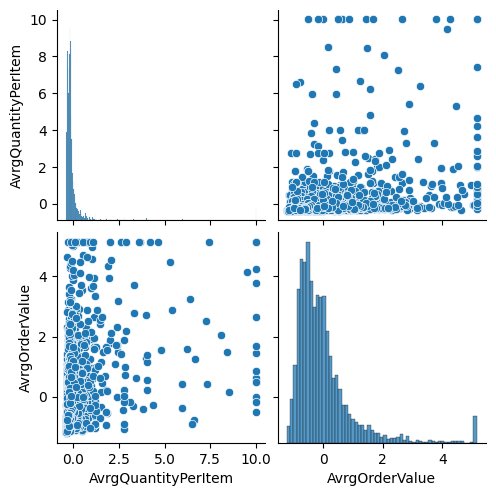

In [39]:
sns.pairplot(cust_norm_clip_stndrd_2_feat)

# Elbow Method, for the optimal number of clusters

I am doing the Elbow Method (most commonly used with clustering algorithms like K-means) to see how the inertia looks depending on the number of clusters.

From the result I can see that doing 4 cluster would be a good option.

In [40]:
cust_norm_clip_stndrd.head()

,AvrgQuantityPerItem,AvrgQuantity,AvrgOrderValue
CustomerID,,,
12346,10.005464,4.865783,5.154360
12747,-0.132466,-0.491018,0.255785
12748,-0.276287,-0.459535,-0.456589
12749,-0.242043,0.492622,1.568550
12820,-0.135559,-0.134269,-0.417358


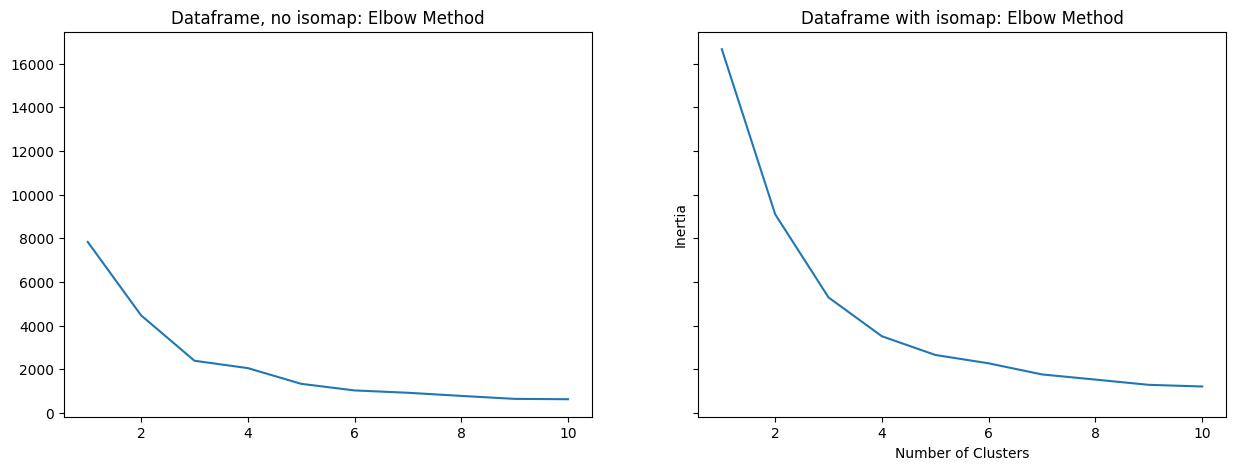

In [41]:
# Finding the optimal number of clusters, looking at my data with reduced dimensionality and without
# these lists are also used later in the code
list_df = [cust_norm_clip_stndrd_2_feat, cust_norm_clip_stndrd_reduced]
list_df_names = ['Dataframe, no isomap', 'Dataframe with isomap']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Checking the plot for 1-10 clusters
for i, (model, model_name) in enumerate(zip(list_df,list_df_names)):
    inertias = []
    for j in range(1,11):
        kmeans = KMeans(n_clusters=j)
        kmeans.fit(model)
        inertias.append(kmeans.inertia_)
    ax[i].plot(range(1,11), inertias)
    ax[i].set_title(f'{model_name}: Elbow Method')
    

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 3 clusters seems good for the no isomap option and 4 best for the option with isomap.

# Building models

Helpful resource:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Models evaluation

While training the models I will use 4 main parameters to compare the models:
- **Silhouette Coefficient:** higher Silhouette Score suggests denser, well-separated clusters
- **Calinski-Harabasz Index:** higher Calinski-Harabasz Index suggests better cluster separation
- **Davies-Bouldin Index:** lower Davies-Bouldin Index indicates better cluster quality
- **Count of customers per cluster:** more evenly dictributed customers per cluster will be better for training models in the future
- **Visual inspection:** checking how the clusters are defined at scatterplot

Helpful resource: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

## Gaussian Mixture clustering

GMM is advantageous if the data potentially forms clusters with different variances and covariances. It is more flexible than K-Means in terms of cluster covariance, allowing for elliptical clusters. It seems that this will much my data (given their charactistics) more.

In [54]:
# Choosing 3 clusters, using function defined in the functions.py
cust_gm,_ = gm_model(cust_norm_clip_stndrd_2_feat, 3)

GaussianMixture silhouette coefficient:  0.6822
GaussianMixture Calinski-Harabasz Index:  2580.7497
GaussianMixture Davies-Bouldin Index:  1.1521
Label: 1, Percentage total customers: 17.97%
Label: 2, Percentage total customers: 5.39%
Label: 0, Percentage total customers: 76.64%


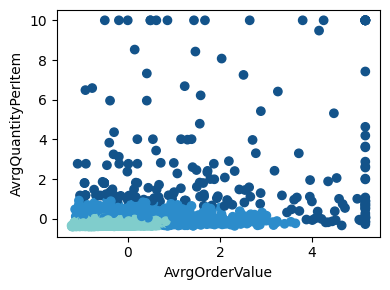

In [55]:
# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm['AvrgOrderValue'], y=cust_gm['AvrgQuantityPerItem'], c=cust_gm['gm_labels'], cmap=ListedColormap(['#2C8CCB', '#36B7DA', '#13538A', '#80CDCC']))
plt.xlabel('AvrgOrderValue')
plt.ylabel('AvrgQuantityPerItem')
plt.tight_layout()
#plt.savefig("../images/clusters_gm_0.png")
plt.show()

## Gaussian Mixture clustering, 3 features + dimensionality reduction

Silhouette Coefficient score has dropped with the following approach (although other metrics have improved). Will not be used.

In [56]:
# Choosing 3 clusters, using function defined in the functions.py
cust_gm2,_ = gm_model(cust_norm_clip_stndrd_reduced, 3)

GaussianMixture silhouette coefficient:  0.5139
GaussianMixture Calinski-Harabasz Index:  2585.2116
GaussianMixture Davies-Bouldin Index:  0.9305
Label: 2, Percentage total customers: 31.02%
Label: 1, Percentage total customers: 64.72%
Label: 0, Percentage total customers: 4.26%


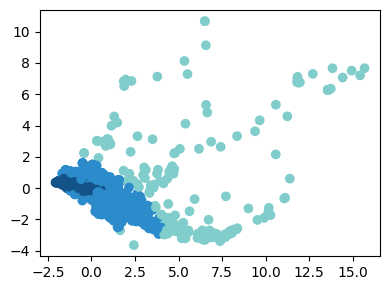

In [57]:
# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm2['Component 1'], y=cust_gm2['Component 2'], c=cust_gm2['gm_labels'], cmap=ListedColormap(['#2C8CCB', '#36B7DA', '#13538A', '#80CDCC']))
plt.tight_layout()
plt.show()

## Clustering with K-Means

I will test K-Means, but I think it will not be the best fit for my data. K-Means assumes that clusters are of similar density and are globular (not my case). K-means can be quite sensitive to oultiers.

Kmeans silhouette coefficient:  0.7737
Kmeans Calinski-Harabasz Index:  5571.8748
Kmeans Davies-Bouldin Index:  0.5259
Label: 1, Percentage total customers: 89.58%
Label: 0, Percentage total customers: 1.05%
Label: 2, Percentage total customers: 9.37%


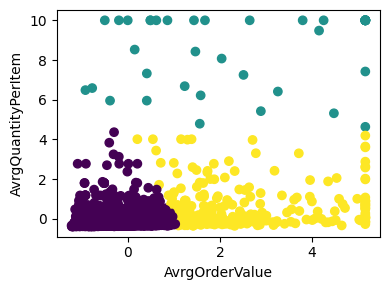

In [58]:
# Choosing 4 clusters, using function defined in the functions.py
cust_kmeans = k_means_model(cust_norm_clip_stndrd_2_feat,3)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans['AvrgOrderValue'], y=cust_kmeans['AvrgQuantityPerItem'], c=cust_kmeans['kmeans_labels'])
plt.xlabel('AvrgOrderValue')
plt.ylabel('AvrgQuantityPerItem')
plt.tight_layout()
#plt.savefig("../images/clusters_kmeans.png")
plt.show()
plt.show()

## Mean shift clustering

MeanShift silhouette coefficient:  0.8709
MeanShift Calinski-Harabasz Index:  1677.9621
MeanShift Davies-Bouldin Index:  0.8276
Label: 1, Percentage total customers: 98.83%
Label: 0, Percentage total customers: 0.54%
Label: 2, Percentage total customers: 0.64%


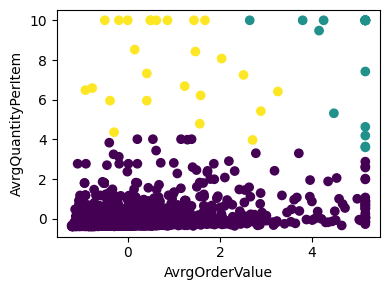

In [59]:
# Function defined in the functions.py . Second parameter is the bandwidth
cust_mshift = mshift_model(cust_norm_clip_stndrd_2_feat,3)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_mshift['AvrgOrderValue'], y=cust_mshift['AvrgQuantityPerItem'], c=cust_mshift['mshift_labels'])
plt.xlabel('AvrgOrderValue')
plt.ylabel('AvrgQuantityPerItem')
plt.tight_layout()
plt.show()

## Clustering with DBSCAN

Will be used for the DBSCAn model.
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc          

A density-based clustering algorithm. I don't believe it will match well my data, cause DBSCAN tends to fall short of identifying clusters with non-uniform density. DBSCAN is effective if there are clear densities in the data, or if we wish to identify outliers as 'noise'. I don't want to define the 'noise' but rather cluster all my data.

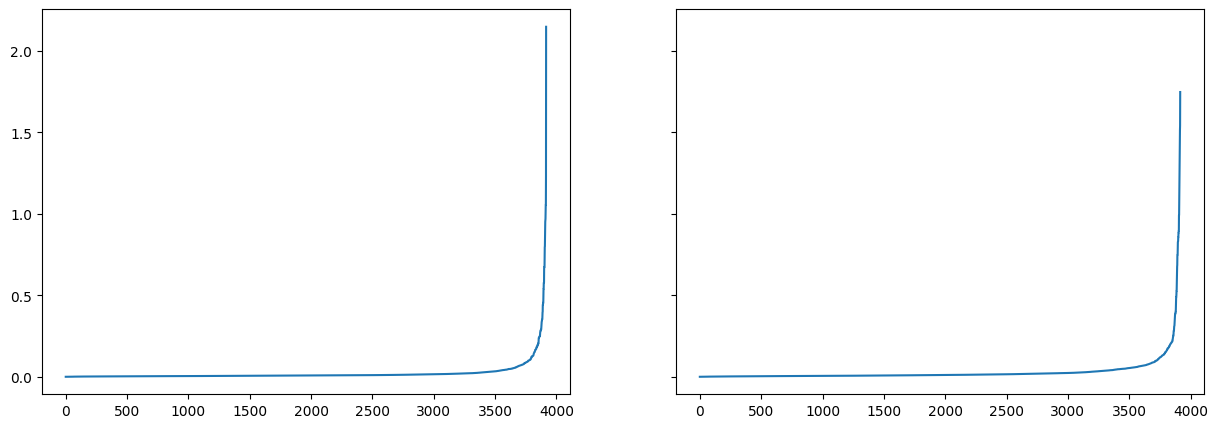

In [60]:
# calculating Optimal Value for Epsilon (EPS)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Checking the plot for 1-10 clusters
for i, model in enumerate(list_df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(model)
    distances, indices = nbrs.kneighbors(model)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    ax[i].plot(distances)

plt.show()

It seems we need a very low Epsilon value close to 0.1 (the optimal value for epsilon is found at the point of maximum curvature).

DBSCAN silhouette coefficient:  0.7476
DBSCAN Calinski-Harabasz Index:  2174.2674
DBSCAN Davies-Bouldin Index:  0.6762
Label: 0, Percentage total customers: 0.28%
Label: 1, Percentage total customers: 89.94%
Label: -1, Percentage total customers: 9.78%


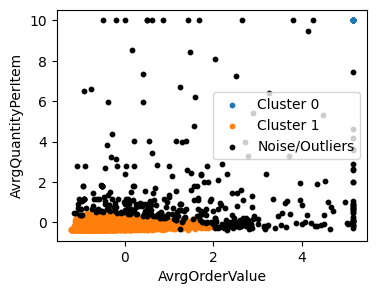

In [61]:
# Training DBSCAN model, eps value, min_samples value, using function defined in the functions.py
cust_dbscan = dbscan_model(cust_norm_clip_stndrd_2_feat, 0.1, 10)

scatter_plot(cust_dbscan[['AvrgOrderValue','AvrgQuantityPerItem']], cust_dbscan['dbscan_labels'])

# Model comparison conclusions

The Gaussian Mixture Model fits better the characteristics of my data, and the version of it with 2 features worked better than the version with 3 features and dimensionality reduction. 
The silhouette score is 0.68 and the Davies-Bouldin Index is 1.15. Both of them could be improved a bit (log transformation, or in real-life scenario where more data would be available, to contruct more features, or with the current data adding maybe the frequency of the orders per client as a feature).
For now I will move further with my analysis.

# Merging clusters to the original dataframe

In [66]:
# Adding the labels to the original dataframe of the customers (before any normalization/ scaling etc)
cust_clust = pd.merge(cust[['AvrgQuantityPerItem','AvrgOrderValue']], cust_gm['gm_labels'], left_index=True, right_index=True)

cust_clust.reset_index(inplace=True)
cust_clust.rename(columns={'index': 'CustomerID','gm_labels':'Cluster'}, inplace=True)

In [67]:
cust_clust.groupby('Cluster')[['AvrgQuantityPerItem','AvrgOrderValue']].mean()

,AvrgQuantityPerItem,AvrgOrderValue
Cluster,,
0,22.346875,544.351591
1,705.000948,2110.265261
2,8.467412,266.321892


Based on the baove info I have interpreted the clusters with the following characteristics:
- Cluster 0 (Low Volume, Moderate Spend): "Casual Buyers"
- Cluster 1 (High Volume, High Spend): "Bulk Buyers"
- Cluster 2 (Low Volume, Low Spend): "Economical Buyers"

In [69]:
cust_clust['Cluster'] = cust_clust['Cluster'].map({0:'Casual Buyers',1:'Bulk Buyers',2:'Economical Buyers'})
cust_clust

,CustomerID,AvrgQuantityPerItem,AvrgOrderValue,Cluster
0,12346,74215.00,92768.75,Bulk Buyers
1,12747,12.38,429.32,Economical Buyers
2,12748,5.87,223.40,Economical Buyers
3,12749,7.42,808.79,Casual Buyers
4,12820,12.24,234.74,Economical Buyers
...,...,...,...,...
3912,18280,4.50,180.75,Economical Buyers
3913,18281,7.71,80.82,Economical Buyers
3914,18282,8.58,76.31,Economical Buyers
3915,18283,1.97,126.76,Economical Buyers


In [70]:
df_merged = pd.merge(df_fltrd, cust_clust[['CustomerID','Cluster']], how='left', on='CustomerID')
df_merged.rename(columns={'gm_labels':'Cluster'}, inplace=True)
df_merged.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom,17.7,Economical Buyers
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,Economical Buyers
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom,33.2,Economical Buyers
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,Economical Buyers
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.5,Economical Buyers


# Saving datasets with clusters

In [71]:
# Saving the dataset that is filtered: Only actual products (good), only UK, dropping NaN customerID (needs to be solved)
# df_merged.to_csv('../data/data_filtered_with_clusters.csv', index=False)